# **MDI 341 : Travaux Pratiques – Chaînes de Markov-HMMs**
***Thomas KOCH***

Ce TP se déroule en deux parties. La première partie concerne les chaînes de Markov et est à
finir absolument. Les plus rapides d’entre vous pourront aborder la deuxième partie qui traite
des HMMs. Les ressources (matrices de transition, modèles HMMs…) sont sur :
- Partie I : http://perso.telecom-paristech.fr/~lauli/TP_Chaine_Markov/
- Partie II : http://perso.telecom-paristech.fr/~lauli/TPHMM_MDI343/

## **Partie 1**
## **I.1 Fonctions dont vous pouvez avoir besoin**
`cumsum` : fonction de répartition : somme cumulative des termes du vecteur $p$
```python
import numpy as np
np.cumsum(p)
```

`random` : génère un nombre aléatoire entre $[0 1]$ selon une loi uniforme.
```python
import numpy as np
np.random.random()
```

`load` : chargement d’un fichier
```python
filename_A = 'bigramenglish.txt'
np.loadtxt(filename_A)
```

Création du dictionnaire clé-valeur associant états et caractères :
```python
dic = {'0':' ', '1':'a', '2':'b', '3':'c', '4':'d', '5':'e', '6':'f', '7':'g',
       '8':'h', '9':'i', '10':'j', '11':'k', '12':'l', '13':'m', '14':'n',
       '15':'o', '16':'p', '17':'q', '18':'r' , '19':'s', '20':'t', '21':'u',
       '22':'v', '23':'w', '24':'x' , '25':'y', '26':'z', '27':' '}
```

Inverser le dictionnaire (les valeurs deviennent les clés et réciproquement)
```python
dic_inv = {v: k for k, v in dic.items()}
```

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn')

In [2]:
plt.style.available
# https://matplotlib.org/3.1.1/gallery/style_sheets/style_sheets_reference.html

['tableau-colorblind10',
 'seaborn-bright',
 'seaborn-poster',
 'ggplot',
 'seaborn',
 'seaborn-muted',
 'seaborn-dark-palette',
 'fast',
 'seaborn-darkgrid',
 'seaborn-talk',
 'Solarize_Light2',
 'classic',
 'fivethirtyeight',
 'bmh',
 'seaborn-pastel',
 'seaborn-deep',
 'seaborn-notebook',
 'seaborn-ticks',
 'seaborn-whitegrid',
 'seaborn-dark',
 'seaborn-paper',
 'grayscale',
 'dark_background',
 '_classic_test',
 'seaborn-white',
 'seaborn-colorblind']

## **I.2 Chaîne de Markov**

On veut générer des mots dans une langue donnée en modélisant la formation de ces mots par une chaîne de Markov. Les 28 états du modèle correspondent aux 26 lettres de l’alphabet auxquelles on ajoute un état "espace initial" (état 1) et un état "espace final" (état 28) qui sert à terminer les mots.

La correspondance entre la valeur numérique d’un état et un caractère est la suivante : l’état 1
correspond à un espace (avant le début d’un mot) et l’état 28 à celui d’un espace en fin de mot. Les états 2 à 27 correspondent aux caractères de *a* à *z*. On pourra utiliser une structure de
dictionnaire en python pour faire cette correspondance.

On utilisera une chaîne de Markov ergodique entre les 26 états correspondants aux lettres de l’alphabet.

### **I.2.a Matrice de transitions**

***'bigramenglish.txt'*** contient la matrice des transitions pour l’anglais (bigrams) entre deux
symboles (caractères ou espaces). Le terme générique $(i,j)$ de la matrice de transition
correspond à la probabilité de transiter vers l’état $j$ à partir de l’état $i$.

A quelles probabilités correspond la première ligne de la matrice de transition ? et celles de la
dernière ligne ?

In [3]:
filename_A = "bigramenglish.txt"
bigram_eng = pd.read_csv(filename_A, sep='   ', header=None, engine='python')

In [4]:
bigram_eng.shape

(28, 28)

In [5]:
bigram_eng.head()

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,0.0,0.112687,0.043609,0.045455,0.032904,0.022094,0.041763,0.015556,0.064438,0.068920,...,0.025680,0.066916,0.164522,0.010388,0.007066,0.070502,0.000105,0.010599,0.000053,0.000000
1,0.0,0.000015,0.022934,0.033960,0.038076,0.000147,0.006174,0.024698,0.000882,0.037047,...,0.094822,0.095410,0.133486,0.011761,0.033372,0.009850,0.000588,0.019847,0.000882,0.067478
2,0.0,0.071874,0.000790,0.000079,0.000790,0.282758,0.000079,0.000079,0.000079,0.070295,...,0.047390,0.015007,0.010268,0.127162,0.001580,0.000079,0.000079,0.106627,0.000079,0.007108
3,0.0,0.136747,0.000041,0.017500,0.001221,0.136747,0.000041,0.000041,0.162794,0.073257,...,0.052501,0.000814,0.087095,0.031338,0.000041,0.000041,0.000041,0.005291,0.000041,0.019535
4,0.0,0.036241,0.000029,0.000029,0.007191,0.136911,0.000863,0.003739,0.000863,0.090028,...,0.018984,0.020134,0.000029,0.020422,0.002876,0.000863,0.000029,0.008629,0.000029,0.598844


> La première ligne de la matrice de transition correspond aux **probabilités de transitions en partant de l'état initial**.

> La dernière ligne de la matrice de transition correspond aux **probabilités de transitions en partant de l'état final**. Cet état signale la fin du mot.

> En résumé, la matrice A ressemble à : 
  
|                  | espace_debut | a | b | ... | z | espace_fin |
|------------------|--------------|---|---|-----|---|------------|
| **espace_debut** |     ...      |...|...| ... |...|   ...      |
| **a**            |     ...      |...|...| ... |...|   ...      |
| **b**            |     ...      |...|...| ... |...|   ...      |
| **...**          |     ...      |...|...| ... |...|   ...      |
| **z**            |     ...      |...|...| ... |...|   ...      |
| **espace_fin**   |      0       | 0 | 0 | ... | 0 |    1       |

> La dernière colonne correspond donc aux **probabilités de transitions pour les différents états de départs possibles**.

Pour chaque lettre de l’alphabet, indiquer la transition la plus fréquente depuis cette lettre. 

In [6]:
dic = {0:' ', 1:'a', 2:'b', 3:'c', 4:'d', 5:'e', 6:'f', 7:'g',
       8:'h', 9:'i', 10:'j', 11:'k', 12:'l', 13:'m', 14:'n',
       15:'o', 16:'p', 17:'q', 18:'r', 19:'s', 20:'t', 21:'u',
       22:'v', 23:'w', 24:'x' , 25:'y', 26:'z', 27:' '}

In [7]:
transition_letters = [dic[x] for x in bigram_eng.idxmax(axis=1)]

for i in range(0,27):
    print("From '{}' state, most frequent transition is '{}'".format(dic[i],transition_letters[i]))

From ' ' state, most frequent transition is 't'
From 'a' state, most frequent transition is 'n'
From 'b' state, most frequent transition is 'e'
From 'c' state, most frequent transition is 'o'
From 'd' state, most frequent transition is ' '
From 'e' state, most frequent transition is ' '
From 'f' state, most frequent transition is ' '
From 'g' state, most frequent transition is ' '
From 'h' state, most frequent transition is 'e'
From 'i' state, most frequent transition is 'n'
From 'j' state, most frequent transition is 'o'
From 'k' state, most frequent transition is ' '
From 'l' state, most frequent transition is 'e'
From 'm' state, most frequent transition is 'e'
From 'n' state, most frequent transition is ' '
From 'o' state, most frequent transition is 'n'
From 'p' state, most frequent transition is 'e'
From 'q' state, most frequent transition is 'u'
From 'r' state, most frequent transition is 'e'
From 's' state, most frequent transition is ' '
From 't' state, most frequent transition

> Les transitions les plus fréquentes depuis chaque état du dictionnaire se trouvent donc ci-dessus.

### **I.2.b Générer un mot**

On veut générer un mot à partir de l’état initial 1 (espace de début de mot).

Ecrire une fonction `etat_suivant` qui génère un état (à $t+1$) à partir de l’état courant (à $t$) à l’aide de la matrice de transitions et de la fonction de répartition. 

In [8]:
def etat_suivant(dic, bigram, state) :
    
    unif = np.random.random()
    #print("unif = {}\n".format(unif))
    
    line_A = bigram.iloc[state]
    
    cum_sum = np.cumsum(line_A)
    #print("cum_sum : \n{}\n".format(cum_sum))
    
    next_state = np.where(cum_sum > unif)[0][0]
    
    #print("=======================\nGenerated state is '{}'".format(next_state))
    
    return next_state

In [154]:
etat_suivant(dic=dic, bigram=bigram_eng, state=0)

unif = 0.1686712075252873

cum_sum : 
0     0.000000
1     0.112687
2     0.156296
3     0.201751
4     0.234655
5     0.256750
6     0.298513
7     0.314069
8     0.378507
9     0.447427
10    0.451065
11    0.455284
12    0.478749
13    0.518509
14    0.541341
15    0.611685
16    0.642744
17    0.644168
18    0.669848
19    0.736764
20    0.901287
21    0.911675
22    0.918741
23    0.989243
24    0.989348
25    0.999947
26    1.000000
27    1.000000
Name: 0, dtype: float64

Generated state is '3'


3

Afficher sur un graphique la fonction de répartition pour une ligne de la matrice de transition et expliquer son rôle pour la génération de l’état à $t+1$.

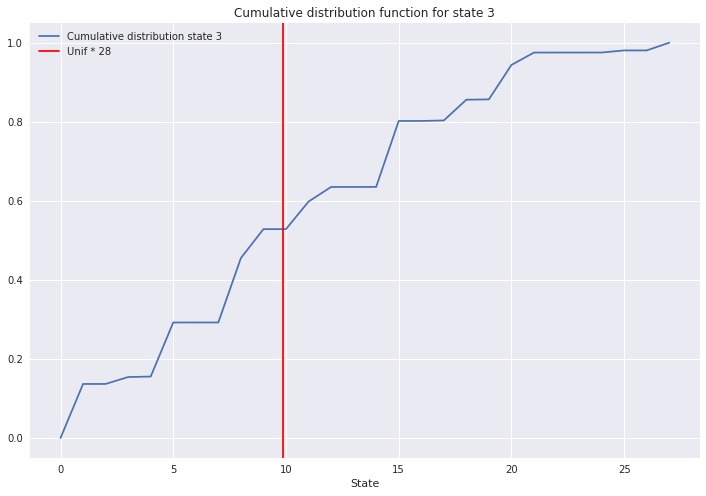

In [12]:
unif = np.random.random()
cum_sum = np.cumsum(bigram_eng.iloc[3])

plt.figure(figsize=(12,8))
plt.title("Cumulative distribution function for state 3")
plt.plot(cum_sum, label='Cumulative distribution state 3')
plt.axvline(unif*28, c='red', label='Unif * 28')
plt.xlabel('State')
plt.ylabel('')
plt.legend()
plt.show()

> La fonction de distribution cumulative nous **permet de trouver quel chiffre (état)** nous devons **prendre en fonction du tirage aléatoire effectué**.

Utiliser cette fonction pour écrire la fonction `genere_state_seq` qui génère une séquence
d’états jusqu’à aboutir à l’état final (27). 

In [9]:
def generate_state_seq(dic, bigram) :
    
    state = 0
    seq = []
    
    while state < 27 :
        state = etat_suivant(dic, bigram, state)
        seq.append(state)

    return seq

In [10]:
generate_state_seq(dic, bigram_eng)

[20, 8, 5, 27]

Ecrire une fonction `display_seq` qui transforme une séquence d’états en séquence de caractères, à l’aide d’un dictionnaire. 

Utiliser ces fonctions pour générer des mots et donner des exemples de mots générés.

In [11]:
def display_seq(dic, bigram) :
    
    sequence = generate_state_seq(dic, bigram)
    len_seq = len(sequence)

    word = []
    for i in range(len_seq):
        word.append(dic[sequence[i]])
    
    return ''.join(word)

In [12]:
display_seq(dic, bigram_eng)

'arst '

In [13]:
for i in range(30):
    print(display_seq(dic, bigram_eng))

twasa 
thes 
anaten 
mete 
toore 
whe 
ar 
par 
amitse 
here 
oftrcak 
othed 
t 
wen 
habid 
he 
isal 
w 
othive 
screeringre 
n 
sthaddund 
k 
e 
bacand 
s 
f 
th 
s 
tor 


> Les mots générés n'existent majoritairement pas

### **I.2.c Générer une phrase**
On veut générer une suite de mots (phrase). 

Créer un état final de phrase (**état 29**, correspondant au caractère ".") dont la probabilité de transition vers cet état depuis un état final de mot est $0.1$. 

> Nous devons donc obtenir une matrice de la forme suivante :

|                  | espace_debut | a | b | ... | z | espace_fin | . |
|------------------|--------------|---|---|-----|---|------------|---|
| **espace_debut** |     ...      |...|...| ... |...|   ...      | 0 |
| **a**            |     ...      |...|...| ... |...|   ...      | 0 |
| **b**            |     ...      |...|...| ... |...|   ...      | 0 |
| **...**          |     ...      |...|...| ... |...|   ...      | 0 |
| **z**            |     ...      |...|...| ... |...|   ...      | 0 |
| **espace_fin**   |     0.9      | 0 | 0 | ... | 0 |    0       |0.1|
| **.**            |      0       | 0 | 0 | ... | 0 |    0       | 1 |

Ecrire une fonction `modify_mat_dic` qui modifie la matrice de transition et le dictionnaire en conséquence. 

In [14]:
def modify_mat_dic(bigram, dic) :
    
    #-------------- Matrix Modification ---------------
    # Append new row at the end of the DataFrame
    new_row = pd.Series(np.zeros(28))
    bigram = bigram.append(new_row, ignore_index=True, sort=False)
    
    # Append new column at the end of the DataFrame
    new_col = pd.Series(np.zeros(29))
    bigram = pd.concat([bigram, new_col], axis=1, ignore_index=True)
    
    # Modify values to have the expected matrix
    bigram.iloc[27, 0] = 0.9
    bigram.iloc[27, 27] = 0.0
    bigram.iloc[27, 28] = 0.1
    bigram.iloc[28, 28] = 1.0
    
    #-------------- Dictionary Modification ---------------
    # Adding a new key value pair in the dictionary
    dic2 = dict(dic)
    dic2.update({28 : '.'})
    
    return bigram, dic2 

In [15]:
bigram_eng2, dic2  = modify_mat_dic(bigram_eng, dic)

In [16]:
dic2

{0: ' ',
 1: 'a',
 2: 'b',
 3: 'c',
 4: 'd',
 5: 'e',
 6: 'f',
 7: 'g',
 8: 'h',
 9: 'i',
 10: 'j',
 11: 'k',
 12: 'l',
 13: 'm',
 14: 'n',
 15: 'o',
 16: 'p',
 17: 'q',
 18: 'r',
 19: 's',
 20: 't',
 21: 'u',
 22: 'v',
 23: 'w',
 24: 'x',
 25: 'y',
 26: 'z',
 27: ' ',
 28: '.'}

In [17]:
bigram_eng2

,0,1,2,3,4,5,6,7,8,9,...,19,20,21,22,23,24,25,26,27,28
0,0.0,0.112687,0.043609,0.045455,0.032904,0.022094,0.041763,0.015556,0.064438,0.068920,...,0.066916,0.164522,0.010388,0.007066,0.070502,0.000105,0.010599,0.000053,0.000000,0.0
1,0.0,0.000015,0.022934,0.033960,0.038076,0.000147,0.006174,0.024698,0.000882,0.037047,...,0.095410,0.133486,0.011761,0.033372,0.009850,0.000588,0.019847,0.000882,0.067478,0.0
2,0.0,0.071874,0.000790,0.000079,0.000790,0.282758,0.000079,0.000079,0.000079,0.070295,...,0.015007,0.010268,0.127162,0.001580,0.000079,0.000079,0.106627,0.000079,0.007108,0.0
3,0.0,0.136747,0.000041,0.017500,0.001221,0.136747,0.000041,0.000041,0.162794,0.073257,...,0.000814,0.087095,0.031338,0.000041,0.000041,0.000041,0.005291,0.000041,0.019535,0.0
4,0.0,0.036241,0.000029,0.000029,0.007191,0.136911,0.000863,0.003739,0.000863,0.090028,...,0.020134,0.000029,0.020422,0.002876,0.000863,0.000029,0.008629,0.000029,0.598844,0.0
5,0.0,0.045607,0.003171,0.018653,0.078064,0.027980,0.009606,0.007181,0.001679,0.016042,...,0.072095,0.023317,0.000466,0.016601,0.008860,0.008394,0.015109,0.000093,0.360474,0.0
6,0.0,0.066869,0.000047,0.000047,0.000047,0.074351,0.033668,0.000047,0.000047,0.077625,...,0.001870,0.046294,0.032733,0.000047,0.000047,0.000047,0.003273,0.000047,0.396540,0.0
7,0.0,0.065942,0.000611,0.000061,0.002442,0.128221,0.000061,0.012212,0.135548,0.062889,...,0.026255,0.006106,0.021370,0.000061,0.000611,0.000061,0.003053,0.000061,0.315667,0.0
8,0.0,0.141975,0.000772,0.000019,0.000019,0.469715,0.000579,0.000019,0.000386,0.140239,...,0.001736,0.024498,0.019097,0.000019,0.001157,0.000019,0.002122,0.000019,0.103009,0.0
9,0.0,0.020688,0.010501,0.076954,0.038085,0.033697,0.023666,0.034010,0.000016,0.000313,...,0.127578,0.117547,0.000940,0.032600,0.000016,0.001097,0.000016,0.006269,0.024607,0.0


Donner des exemples de phrases générées.

In [18]:
def generate_state_seq2(dic, bigram) :
    
    state = 0
    seq = []
    
    while state < 28 :
        state = etat_suivant(dic, bigram, state)
        seq.append(state)

    return seq

In [19]:
def display_seq2(dic, bigram) :
    
    sequence = generate_state_seq2(dic, bigram)
    len_seq = len(sequence)

    word = []
    for i in range(len_seq):
        word.append(dic[sequence[i]])
    
    return ''.join(word)

In [20]:
for i in range(20):
    print()
    print(display_seq2(dic2, bigram_eng2))


thtamad  t  i  m  an  thivisth  sthndowharr  fussuse  wolanamistha  or  an  wnd  thedubobond  hint  oracoicthes  ted  ro  ay  icexe  ave  ighir  wilimes  u  thamand  inle  thetionforizat  anirecapr  d  t  alpricr  ar  a .

woraveang  funcondemovem  aks  ckercaventhas  s  s  ave  e  lanorar  pond  s  onedsibed  lye  ty  t  d  wasts  orys  wer  ten  the  gredireen  conungr  tit  purelensangy  ounthile  any  o  yo  yonchthes  tan  he  awale  sonlound .

nofrst  ffe  gin  qullere  t  than  rrvitind  ted  tick  no  heremofon .

toowionind  tof  iminns .

ersched  isly  ond  wirank  bonghemor  omerp  t  of  tofond  we  ima  g  arofairaven  whas  ia  toudethoshedlus  whugily  u  alltedies .

th  tmsedofey  of  ily  theavis  wanghn .

thagh  fris  kelinildarereecelves  de .

d  panothantly  he  tialely  sonthasime  c  ise  nglve  wo  fane  an  rw  athef .

my  wenis  wofofon  hene  the  ed  ave  thlothegofe  tily  be  clle  todemfod  ce  iterentheene  lof  rig  inhoscky  aro  repato  whis  id

> Globalement nous arrivons à générer des phrases avec cette nouvelle matrice. Toutefois, difficile d'interpréter ce que nous générons.

## **I.3. Reconnaissance de la langue**

Charger la matrice des transitions entre caractères pour le français. 

In [21]:
filename_B = "bigramfrancais.txt"
bigram_fr = pd.read_csv(filename_B, sep='   ', header=None, engine='python')

In [22]:
bigram_fr.shape

(28, 28)

In [29]:
bigram_fr2, _ = modify_mat_dic(bigram_fr, dic)

In [30]:
bigram_fr2

,0,1,2,3,4,5,6,7,8,9,...,19,20,21,22,23,24,25,26,27,28
0,0.0,0.076217,0.011726,0.070354,0.206175,0.067422,0.021497,0.010748,0.000977,0.019543,...,0.060582,0.013680,0.034200,0.006840,0.000098,0.000098,0.000098,0.000977,0.000000,0.0
1,0.0,0.000341,0.003414,0.023899,0.003414,0.000341,0.010242,0.013657,0.000341,0.058040,...,0.081939,0.119495,0.133151,0.020485,0.000341,0.000341,0.000341,0.000341,0.157050,0.0
2,0.0,0.030992,0.001033,0.001033,0.001033,0.020661,0.001033,0.001033,0.001033,0.289256,...,0.010331,0.001033,0.185950,0.001033,0.001033,0.001033,0.001033,0.001033,0.001033,0.0
3,0.0,0.040241,0.000402,0.008048,0.008048,0.301811,0.000402,0.000402,0.060362,0.209256,...,0.000402,0.040241,0.040241,0.000402,0.000402,0.000402,0.000402,0.000402,0.032193,0.0
4,0.0,0.036174,0.000402,0.000402,0.000402,0.546624,0.004019,0.000402,0.000402,0.124598,...,0.008039,0.000402,0.056270,0.000402,0.000402,0.000402,0.000402,0.000402,0.080386,0.0
5,0.0,0.001117,0.029034,0.023451,0.005583,0.012284,0.010050,0.004467,0.000112,0.003350,...,0.173088,0.045784,0.032384,0.006700,0.000112,0.008934,0.000112,0.001117,0.337242,0.0
6,0.0,0.088496,0.001475,0.001475,0.001475,0.176991,0.088496,0.001475,0.001475,0.265487,...,0.044248,0.014749,0.029499,0.001475,0.001475,0.001475,0.001475,0.001475,0.001475,0.0
7,0.0,0.051348,0.001284,0.001284,0.001284,0.115533,0.001284,0.001284,0.001284,0.462131,...,0.001284,0.001284,0.064185,0.001284,0.001284,0.001284,0.001284,0.001284,0.012837,0.0
8,0.0,0.218579,0.005464,0.005464,0.005464,0.437158,0.005464,0.005464,0.005464,0.163934,...,0.005464,0.005464,0.005464,0.005464,0.005464,0.005464,0.005464,0.005464,0.054645,0.0
9,0.0,0.065735,0.092440,0.145850,0.004108,0.112983,0.028759,0.014380,0.000205,0.000205,...,0.110929,0.071898,0.002054,0.018488,0.000205,0.000205,0.000205,0.000205,0.030813,0.0


Ecrire une fonction `calc_vraisemblance` qui calcule la vraisemblance du modèle français pour une phrase donnée en multipliant les probabilités de transition. 

Pour tenir compte de toutes les transitions (notamment celles entre espaces de fin et de début de mots et vers la fin de phrase) on pourra transformer une séquence ***« mot1 mot2.»*** par la séquence ***« -mot1+-mot2+.»***, les signes ***-*** , ***+*** et ***.*** représentant l’état initial de mot, l’état final de mot et l’état final de phrase, respectivement.

In [33]:
dic3 = {0:'-', 1:'a', 2:'b', 3:'c', 4:'d', 5:'e', 6:'f', 7:'g',
       8:'h', 9:'i', 10:'j', 11:'k', 12:'l', 13:'m', 14:'n',
       15:'o', 16:'p', 17:'q', 18:'r', 19:'s', 20:'t', 21:'u',
       22:'v', 23:'w', 24:'x' , 25:'y', 26:'z', 27:'+', 28:'.'}

In [34]:
dic3

{0: '-',
 1: 'a',
 2: 'b',
 3: 'c',
 4: 'd',
 5: 'e',
 6: 'f',
 7: 'g',
 8: 'h',
 9: 'i',
 10: 'j',
 11: 'k',
 12: 'l',
 13: 'm',
 14: 'n',
 15: 'o',
 16: 'p',
 17: 'q',
 18: 'r',
 19: 's',
 20: 't',
 21: 'u',
 22: 'v',
 23: 'w',
 24: 'x',
 25: 'y',
 26: 'z',
 27: '+',
 28: '.'}

In [38]:
def calc_vraisemblance(dic, bi_eng, bi_fr, seq) :
    
    key_0 = 0
    trans_eng = 1
    trans_fr = 1
    
    for letter in seq : 
        key_1 = [key for key, val in dic.items() if val == letter][0]
        
        trans_eng = trans_eng * bi_eng.iloc[key_0, key_1]
        trans_fr = trans_fr * bi_fr.iloc[key_0, key_1]
        
        key_0 = [key for key, val in dic.items() if val == letter][0]
    
    if trans_eng > trans_fr :
        print("La séquence testée est en anglais.")
    else : 
        print("La séquence testée est en français.")
    
    return trans_eng, trans_fr

Calculer la vraisemblance des modèles français et anglais pour la phrase ***« to be or not to be »***.

De même calculer la vraisemblance des modèles français et anglais pour la phrase ***« etre ou ne
pas etre »***.

In [39]:
calc_vraisemblance(dic3, bigram_eng2, bigram_fr2, 'to+-be+-or+-not+-to+-be+.')

La séquence testée est en anglais.


(8.112892227809416e-20, 5.960208101868643e-30)

In [40]:
calc_vraisemblance(dic3, bigram_eng2, bigram_fr2, 'etre+-ou+-ne+-pas+-etre+.')

La séquence testée est en français.


(4.462288711775254e-24, 1.1457068872347888e-19)

## **Partie 2**
## **II. 1. Introduction**

L’objectif de cette partie est de générer des séquences d’observations suivant un modèle de
Markov Caché donné, puis de calculer la vraisemblance d’une séquence d’observations suivant un modèle de Markov Caché donné.

Le modèle de Markov est de type discret. Les classes de caractères (classes 0, 1, 7) sont
modélisées chacune par un modèle à $Q = 5$ états de type gauche-droite. Les **états 1 et 5**
correspondent à des **colonnes de pixels de type fond de l’image (niveau 0)**. Les états **2, 3 et 4** correspondent au **début, milieu et fin du caractère** respectivement. Les transitions entre états sont indiquées dans la matrice de transitions $A$ de taille $Q\times Q$. Les vecteurs $π$ sont tous égaux à $π = (1 0 0 0 0)$. Les séquences d’états commencent donc toujours par l’état $q_1 = 1$. 

Les séquences d’observations sont discrètes et issues d’images de chiffres de la base MNIST.
Les séquences d’observations consistent en séquences d’index (symboles) des éléments du
dictionnaire. Ce dictionnaire est stocké sous forme matricielle (matrice $v$) dans le fichier
`matrice_symboles`. L’élément numéro $i$ d’une séquence d’observations correspond au symbole $i$ et donc à la colonne $i$ de la matrice $v$. Un symbole correspond à une configuration de colonne de 5 pixels (binaires : noir/blanc). Il y a $2^5 = 32$ configurations, et donc symboles possibles.

Une séquence d’observations correspondant à l’image simplifiée de la fig. 1 est :

$$
[1\ 1\ 1\ 1\ 1\ 1\ 14\ 23\ 23\ 27\ 18\ 18\ 18\ 12\ 12\ 12\ 12\ 12\ 12\ 12\ 23\ 23\ 23\ 14\ 4\ 1\ 1\ 1]
$$

La concaténation des éléments du dictionnaire correspondant aux index de la séquence d’observations peut être visualisée sous forme d’image en remplaçant chaque index par le vecteur de pixels correspondant dans le dictionnaire (Fig. 2 du sujet). 


## **II. 2. Génération de séquences d’observations**

Les matrices `A0.txt`, `B0.txt`, `vect_pi0.txt` contiennent les matrices $A$, $B$, et le vecteur $π$ correspondant au modèle de Markov caché du chiffre 0. Le fichier `matrice_symboles.txt`
contient le dictionnaire. Charger ces fichiers depuis le site pédagogique. 

Le dictionnaire de symboles se trouve dans la matrice $v$ qui se charge en utilisant :

```python
import numpy as np
filename = 'matrice_symboles.txt'
v = np.loadtxt(filename)
```

In [66]:
A0 = pd.DataFrame(np.loadtxt('data_txt_compact/A0.txt'))
B0 = pd.DataFrame(np.loadtxt('data_txt_compact/B0.txt'))
Pi0 = pd.DataFrame(np.loadtxt('data_txt_compact/vect_pi0.txt'))

## **II. 2.1**

A quoi correspondent les zéros de la matrice $B$ ? et ceux de la matrice $A$ et du vecteur $π$ ?

In [67]:
A0

,0,1,2,3,4
0,0.841781,0.158219,-0.000000,-0.000000,-0.000000
1,-0.000000,0.788616,0.211384,-0.000000,-0.000000
2,-0.000000,-0.000000,0.863397,0.136603,-0.000000
3,-0.000000,-0.000000,-0.000000,0.791502,0.208498
4,-0.000000,-0.000000,-0.000000,-0.000000,1.000000


In [68]:
B0

,0,1,2,3,4
0,1.0,-0.000000,-0.000000,-0.000000,1.0
1,-0.0,0.000348,0.000409,0.000409,-0.0
2,-0.0,0.000348,0.000409,0.018038,-0.0
3,-0.0,0.077917,0.000409,0.129038,-0.0
4,-0.0,0.011896,0.016747,0.000409,-0.0
5,-0.0,0.000348,0.000409,0.000409,-0.0
6,-0.0,0.000348,0.002605,0.000031,-0.0
7,-0.0,0.000348,0.000409,0.000409,-0.0
8,-0.0,0.000348,0.024108,0.000409,-0.0
9,-0.0,0.000348,0.000409,0.000409,-0.0


In [69]:
Pi0

,0
0,1.0
1,0.0
2,0.0
3,0.0
4,0.0


In [71]:
filename = 'data_txt_compact/matrice_symboles.txt'
v = pd.DataFrame(np.loadtxt(filename))

In [72]:
v

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0
1,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0


> L'élément ...... (A COMPLETER)